# Predicting Boston housing price
> This example is from Deep learning with python book.  


Regression is machine-learning problem which consist of predicting a continous value instead of a discreate label.   
Steps to solve regression problem:   
1. Load the data
2. Become one with data
3. Preprocess the data
4. Build the model
5. Evaluate and visualize the model
6. Repeat untill state-of-art model
7. Save the model  


## 1. Load the data
Attempting to predict the median price of homes in given Boston suburb in mid 1970's, from given data points. This a toy-dataset which comes with keras.   

In [2]:
import tensorflow as tf
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) =  boston_housing.load_data()

57026/57026 [==============================] - 0s 0us/step


## 2. Become one with data
let's look the data

In [3]:
# check labels
train_targets[0]

15.2

In [4]:
print(f"Training data: {train_data.shape}")
print(f"Testing data: {test_data.shape}")
print(f"Training sample: {train_data[10]}")
print(f"Training target sample: {train_targets[10]}")


Training data: (404, 13)
Testing data: (102, 13)
Training sample: [  9.59571   0.       18.1       0.        0.693     6.404   100.
   1.639    24.      666.       20.2     376.11     20.31   ]
Training target sample: 12.1


In [5]:
train_data.dtype, train_targets.dtype

(dtype('float64'), dtype('float64'))

In [6]:
test_targets

array([ 7.2, 18.8, 19. , 27. , 22.2, 24.5, 31.2, 22.9, 20.5, 23.2, 18.6,
       14.5, 17.8, 50. , 20.8, 24.3, 24.2, 19.8, 19.1, 22.7, 12. , 10.2,
       20. , 18.5, 20.9, 23. , 27.5, 30.1,  9.5, 22. , 21.2, 14.1, 33.1,
       23.4, 20.1,  7.4, 15.4, 23.8, 20.1, 24.5, 33. , 28.4, 14.1, 46.7,
       32.5, 29.6, 28.4, 19.8, 20.2, 25. , 35.4, 20.3,  9.7, 14.5, 34.9,
       26.6,  7.2, 50. , 32.4, 21.6, 29.8, 13.1, 27.5, 21.2, 23.1, 21.9,
       13. , 23.2,  8.1,  5.6, 21.7, 29.6, 19.6,  7. , 26.4, 18.9, 20.9,
       28.1, 35.4, 10.2, 24.3, 43.1, 17.6, 15.4, 16.2, 27.1, 21.4, 21.5,
       22.4, 25. , 16.6, 18.6, 22. , 42.8, 35.1, 21.5, 36. , 21.9, 24.1,
       50. , 26.7, 25. ])

> We have 404 training samples and 102 test samples, each with 13 numerical features, such as per capita crime rate, average no. of rooms per dwelling, tax-rate, and so on.
 Targets are median values of owner occupied homes, in thousand dollars.

## 3. Preprocess the data
There is no categorical data so, we are going to feature-wise normalization: for each input in the data(column in input data matrix), you substract the mean of the feature and divide by standard deviation, so that feature is centered around 0 and has a unit standard deviation.  

In [7]:
# normalizing(standardization) the data
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis= 0)
train_data /= std

test_data -= mean
test_data /= std

**Note:** Quantities used for normalizing the test data are computed using the training data. You should never use in workflow any quantity computed using the test data, even for something as simple as data normalization.

In [8]:
# check sample
train_data[0]

array([-0.27224633, -0.48361547, -0.43576161, -0.25683275, -0.1652266 ,
       -0.1764426 ,  0.81306188,  0.1166983 , -0.62624905, -0.59517003,
        1.14850044,  0.44807713,  0.8252202 ])

## 4. Building network
* Build the model
* Compile the model
* Fit the model

> Because we only have few samples, we'll use a very small network with two hidden layers, each with 64 units. In general, the less training data you have, the worse overfitting will be, and using a small network is one way to mitigate overfitting.

In [9]:
# Creating a function because we can instantiate the same model multiple times

def build_model():
  """
  Returns the simple model
  """
  model = tf.keras.Sequential([
      tf.keras.layers.Dense(64, activation="relu",
                            input_shape=(train_data.shape[1],)),
      tf.keras.layers.Dense(64, activation="relu"),
      tf.keras.layers.Dense(1)])
  model.compile(
      loss = "mse",
      optimizer="rmsprop",
      metrics=["mae"])

  return model

We have very few data points, so the validation set would end up being very small. As a consequence, the validation scores might change a lot depending on which data points we choose to use for validation and which we choose for training:the validation score might have a high variance with regard to validation split.This would prevent us from reliably evaluating the model.

The best practice in such situations is to use `K-fold cross-validation`. It consists of splitting the available data on K partitions (typically K = 4 or 5), instantiating K identical models, and training each one on K-1 partitions while evaluating on the remaining partition. The validation score for the model used is the average of the K validation scores obtained.


### **K-fold validation**

In [10]:
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []

for i in range(k):
    print('Processing fold #', i)
    val_data = train_data[i * num_val_samples:(i + 1) * num_val_samples]  # prepares validation data: data from partition #k
    val_targets = train_targets[i * num_val_samples:(i + 1) * num_val_samples]

    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]], axis=0)  # prepares the training data from all other partitions

    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]], axis=0)

    model = build_model()  # build the Keras model (already compiled)
    model.fit(partial_train_data, partial_train_targets, epochs=num_epochs, batch_size=1, verbose=0)  # trains the model in silent mode
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)  # evaluates the model on the validation data
    all_scores.append(val_mae)


Processing fold # 0
Processing fold # 1
Processing fold # 2
Processing fold # 3


In [11]:
# check the validation scores
all_scores

[2.087677240371704, 2.6425156593322754, 2.51343035697937, 2.4270153045654297]

In [12]:
# check the mean
np.mean(all_scores)

2.417659640312195

Difference ranges from 2.31 to 2.49.. The average(2.4) is much reliable metric than any single score. In this case we're off by  \$2400 on average which is quite significant considering the price range viz. \$10,000 to \$50,000.  

> Let's train model for bit longer:500 epochs. To keep a record of how well teh model does at each epoch, we'll modify the training loop to save the per epoch validation score log

In [13]:
k = 4
num_val_samples = len(train_data) // k
num_epochs = 500
all_mae_histories = []

for i in range(k):
    print('Processing fold #',i )
    val_data = train_data[i * num_val_samples:(i + 1 ) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i +1) * num_val_samples]  #prepares the validation data: data from partition #k

    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i+1) * num_val_samples:]], axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i+1) * num_val_samples:]], axis=0)

    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets, validation_data=(val_data, val_targets), epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

Processing fold # 0
Processing fold # 1
Processing fold # 2
Processing fold # 3


Building the history of successive mean k-fold validation scores

In [15]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

### Plotting validation scores

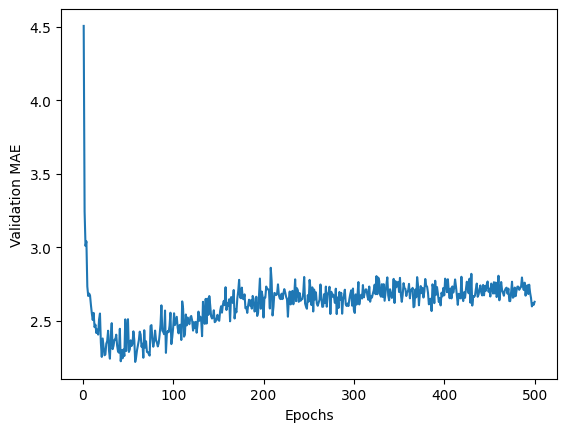

In [16]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history)+1), average_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

It may be little difficult to see the plot, due to scaling issues and relatively high  variance. Let's do the following:
* Omit the first 10 data points, which are on a different scale than the rest of the curve.
* Replace each point with an exponential moving average of the previous points, to obtain a smooth curve

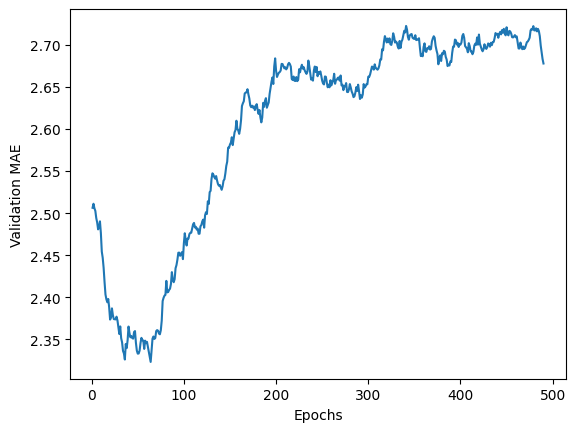

In [17]:
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * ( 1- factor))
    else:
      smoothed_points.append(point)
  return smoothed_points


smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history)+1), smooth_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

According to this plot, validation MAE stops improving significantly after 70 epochs. Past that it seems overfitting.

> Training final model

In [18]:
# Get a fresh compiled model
model = build_model()

# fit the model on fuel data
model.fit(train_data, train_targets,
          epochs=70, batch_size=16, verbose=0)
tse_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

4/4 [==============================] - 0s 4ms/step - loss: 18.7090 - mae: 2.7118


### Final results

In [19]:
test_mae_score

2.711793899536133

We're still off by about \$2,712.

**Key takeaways**:
 * When there is little data available, using K-fold validation is a great way to reliably evaluate a model
 * When little training data is avialable, it's preferable to use small network with few hidden layers(typically one or two), in order to avoid overfitting.  